## DE Portfolio 5: Bayes Decision Trees

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to classify whether an attack will end up in property damage given certain attack details and features.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
#Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np

from scipy.stats import beta, norm, bernoulli

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from decimal import Decimal

import ID3  # decision tree module

### Load and Prepare GTD Data

In [2]:
#Load GTD data and apply filters
df=pd.read_csv('Data_All.csv')
df = df[df['region_txt'].isin(['North America', 'Western Europe', 'Eastern Europe'])]
display(df)

C:\Users\maria\AppData\Local\Temp\ipykernel_20936\1975629144.py:2: DtypeWarning: Columns (4,31,33,37,54,61,62,63,76,79,90,92,94,96,114,115,121,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data_All.csv')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
5,197001010002,1970,1,1,NaN,0,NaN,217,United States,1,...,"""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN,NaN
7,197001020002,1970,1,2,NaN,0,NaN,217,United States,1,...,Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...",NaN,Hewitt Project,-9,-9,0,-9,NaN,NaN
8,197001020003,1970,1,2,NaN,0,NaN,217,United States,1,...,"Tom Bates, ""Rads: The 1970 Bombing of the Army...","David Newman, Sandra Sutherland, and Jon Stewa...","The Wisconsin Cartographers' Guild, ""Wisconsin...",Hewitt Project,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214599,202106280011,2021,6,28,NaN,0,NaN,38,Canada,1,...,"""Fire at Catholic church on Siksika First Nati...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Place of Worship
214635,202106290017,2021,6,29,NaN,0,NaN,38,Canada,1,...,"""RCMP investigates suspected arson at Alberta ...","""Fire at Catholic church on Siksika First Nati...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Place of Worship
214637,202106290019,2021,6,29,NaN,0,NaN,603,United Kingdom,8,...,"""Arson: Disgust at attacks on offices of two M...","""Arson attack on Alliance MLA Kellie Armstrong...","""Attack on Alliance and UUP offices‘unacceptab...",START Primary Collection,-9,-9,1,1,NaN,Politician or Political Party Movement/Meeting...
214652,202106300007,2021,6,30,NaN,0,NaN,38,Canada,1,...,"""Another Canadian church has been set on fire ...","""Morinville Church was destroyed by fire, arso...","""RCMP investigate suspicious fire at Catholic ...",START Primary Collection,-9,-9,0,-9,NaN,Place of Worship


#### Features selected
1. region_txt: categorical value for regions where attacks took place
    - For this model we focus on Europe and North America
2. doubtterr: Binary value, explains whether there were doubts about the attack being organized by a terrorist group (1= Doubts, 0= No doubts)

3. attacktype1_txt: categorical value defining the attack type of the event

4. targtype1_txt: (categorical value) explaining the types of targets attacked by the terrorist organisation
5. property: If a property was attacked during the terrorist incident  (1 = Yes; 0 = No)

6. crit1: binary value explaining whether the attack had a political, social or economic goal (1=Yes; 0=No)

7. crit2: binary value representing whether the attack had the intention to coerce or intimidate the public (1=Yes; 0=No)





In [3]:
#Select relevant features
features=['doubtterr', 'attacktype1_txt', 'targtype1_txt', 'crit1', 'crit2', 'property']
df=df[features]

#Replace unknown, other and -9 values with Nan and remove them
values_to_replace = ['Unknown', 'Other']
df.replace(values_to_replace, np.nan, inplace=True)
df.replace(-9, np.nan, inplace=True)
df=df.dropna()

In [4]:
#Map attack types into broader categories to reduce complexity
group_1=['Assassination', 'Armed Assault', 'Hijacking', 'Unarmed Assault'] #attacks related to direct violence
group_2=['Hostage Taking (Barricade Incident)', 'Hostage Taking (Kidnapping)'] #coercion oritentated attacks
group_3=['Bombing/Explosion', 'Facility/Infrastructue Attack'] #Explosive attacks

#Group attacks and store them into a dictionary
attacks={} #Initialize an empty dictionary for attacks
g1_map = {attack: 'Direct Violence' for attack in group_1} #Assign first group to direct violence category
attacks.update(g1_map) # Add these attacks into a dictionary

#Repeat this for all groups
g2_map = {attack: 'Coercion Attack' for attack in group_2}
attacks.update(g2_map)
g3_map = {attack: 'Explosive Attacks' for attack in group_3}
attacks.update(g3_map)

#Replace all attack types with the new categories
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)

#Repeat the same process of target types
tg1=['Government (General)', 'Government (Diplomatic)', 'Military', 'Police',
      'Terrorsits/Non-state Militias', 'Violent Political Party'] #Political, law enforcement
tg2=['Business', 'Educational Institution', 'NGO', 'Religous Figures/Institutions'] #Business related
tg3=['Abortion Related', 'Food or Water Supply', 'Telecommunication', 'Utilities'] #Essential services or needs
tg4=['Airport & Aircraft', 'Transportation (Other Than Aviation)', 'Maritime'] #Transportation related
tg5=['Private Citizens & Property', 'Journalists & Media', 'Tourists'] #Civillians

targets={} #Initialize empty dictionary
#Add target types to groups
t1_map = {target: 'Political' for target in tg1}
targets.update(t1_map)
t2_map = {target: 'Institutions' for target in tg2}
targets.update(t2_map)
t3_map = {target: 'Essential Services' for target in tg3}
targets.update(t3_map)
t4_map = {target: 'Transportation' for target in tg4}
targets.update(t4_map)
t5_map = {target: 'Civillians' for target in tg5}
targets.update(t5_map)
#Replace dataframe target types with the newly formed categories
df['targtype1_txt'] = df['targtype1_txt'].replace(targets)

df = df.astype(str)

In [5]:
copy=df.copy()
display(copy)

,doubtterr,attacktype1_txt,targtype1_txt,crit1,crit2,property
1,0.0,Coercion Attack,Political,1,1,0.0
3,0.0,Explosive Attacks,Political,1,1,1.0
5,0.0,Direct Violence,Political,1,1,1.0
7,1.0,Explosive Attacks,Essential Services,1,1,1.0
8,0.0,Facility/Infrastructure Attack,Political,1,1,1.0
...,...,...,...,...,...,...
214599,0.0,Facility/Infrastructure Attack,Religious Figures/Institutions,1,1,1.0
214635,0.0,Facility/Infrastructure Attack,Religious Figures/Institutions,1,1,1.0
214637,0.0,Facility/Infrastructure Attack,Political,1,1,1.0
214652,0.0,Facility/Infrastructure Attack,Religious Figures/Institutions,1,1,1.0


In [6]:
#Property damage - will be the target feature
property = {'0.0': 'no damage', '1.0': 'property damage'}
copy['property'] = copy['property'].replace(property)


#Doubt - confirms if an attack was classified as a terrorist attack
doubt = {'0.0': 'terrorism', '1.0': 'unsure'}
copy['doubtterr'] = copy['doubtterr'].replace(doubt)

#Crit1 - If the attack was driven by social, political, relgious, economic motives
ideology = {'0': 'ideology motivated', '1': 'no motives'}
copy['crit1'] = copy['crit1'].replace(ideology)

#Crit2 - If the goal was intimidate population
intimidation = {'0': 'intimidation goal', '1': 'no intimidation'}
copy['crit2'] = copy['crit2'].replace(intimidation)

display(copy)


,doubtterr,attacktype1_txt,targtype1_txt,crit1,crit2,property
1,terrorism,Coercion Attack,Political,no motives,no intimidation,no damage
3,terrorism,Explosive Attacks,Political,no motives,no intimidation,property damage
5,terrorism,Direct Violence,Political,no motives,no intimidation,property damage
7,unsure,Explosive Attacks,Essential Services,no motives,no intimidation,property damage
8,terrorism,Facility/Infrastructure Attack,Political,no motives,no intimidation,property damage
...,...,...,...,...,...,...
214599,terrorism,Facility/Infrastructure Attack,Religious Figures/Institutions,no motives,no intimidation,property damage
214635,terrorism,Facility/Infrastructure Attack,Religious Figures/Institutions,no motives,no intimidation,property damage
214637,terrorism,Facility/Infrastructure Attack,Political,no motives,no intimidation,property damage
214652,terrorism,Facility/Infrastructure Attack,Religious Figures/Institutions,no motives,no intimidation,property damage


In [7]:
copy = copy.rename(columns={'property': 'class'}) #Rename target value to class to ensure compatibility with ID3

#Drop target values and set X
columns_drop=[ 'class'] 
X = copy.drop(columns_drop, axis=1)

#Set Y (target column)
y = copy['class']

#Convert Y to dataframe to ensure compatibility with model
y = pd.DataFrame(y, columns=['class'])

#Concat y and x to run ID3 model
data_for_id3 = pd.concat([X, y], axis=1)

#Split data into train and test sets
data_train, data_test = train_test_split(data_for_id3, test_size=0.2, random_state=42)

### ID3 Decison Tree Model

In [8]:
#Arrange features of train set into a list
features = list(data_train.columns[:-1])
display(features)

#Create decsion tree using ID3
decision_tree = ID3.ID3(data_train, data_train, features, 'class')

['doubtterr', 'attacktype1_txt', 'targtype1_txt', 'crit1', 'crit2']

In [9]:
#Print decision tree structure
ID3.print_tree(decision_tree)

attacktype1_txt
|--- Coercion Attack
|   |--- crit2
|   |   |--- intimidation goal
|   |   |   |--- targtype1_txt
|   |   |   |   |--- Civillians
|   |   |   |   |   |--- no damage
|   |   |   |   |--- Institutions
|   |   |   |   |   |--- doubtterr
|   |   |   |   |   |   |--- terrorism
|   |   |   |   |   |   |   |--- crit1
|   |   |   |   |   |   |   |   |--- no motives
|   |   |   |   |   |   |   |   |   |--- property damage
|   |   |   |   |   |   |--- unsure
|   |   |   |   |   |   |   |--- crit1
|   |   |   |   |   |   |   |   |--- no motives
|   |   |   |   |   |   |   |   |   |--- property damage
|   |   |   |   |--- Religious Figures/Institutions
|   |   |   |   |   |--- no damage
|   |   |   |   |--- Terrorists/Non-State Militia
|   |   |   |   |   |--- doubtterr
|   |   |   |   |   |   |--- unsure
|   |   |   |   |   |   |   |--- crit1
|   |   |   |   |   |   |   |   |--- no motives
|   |   |   |   |   |   |   |   |   |--- no damage
|   |   |--- no intimidation
|   |   |   

##### Decision Tree Interpretation
The root node, also the most important node, is represented by attack types. This is followed by the criteria regarding intimidation or coercion, and then the type of targets affected by the terrorist incident, or presence of doubt and motives. These are the internal nodes leading to the leaf node which shows the outcome: whether the terrorist incident resulted in property damage or not.


#### Generate and Compare Predictions

In [10]:
#Drop outcome value from test set
test_features = data_test.drop('class', axis=1)

#Get predictions 
predicted = ID3.predictDataset(test_features, decision_tree, default="no damage")


#Compare predictions and true values
true= data_test['class'].tolist()
comparison = pd.DataFrame({'True': true, 'Predicted': predicted})

display(comparison)

,True,Predicted
0,no damage,property damage
1,property damage,no damage
2,property damage,property damage
3,property damage,property damage
4,property damage,property damage
...,...,...
4305,property damage,property damage
4306,no damage,no damage
4307,property damage,property damage
4308,no damage,property damage


#### Evaluate ID3 Decision Tree

Accuracy: 0.8223


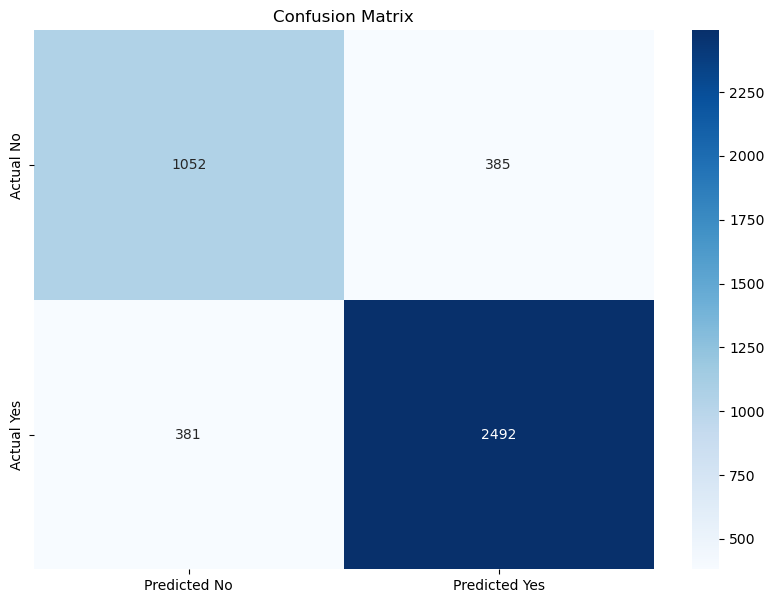

In [11]:
#Calculate accuracy
accuracy = accuracy_score(true, predicted)
print(f"Accuracy: {accuracy:.4f}")

#Create confusion matrix and plot it
conf_matrix = confusion_matrix(true, predicted)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.show()

### CART Decision Tree Model

#### Prepare Data and Fit Model

In [12]:
#Encode categorical values to have them as independent columns
target_dummies = pd.get_dummies(df['targtype1_txt'], drop_first=True).astype(int)
attack_dummies = pd.get_dummies(df['attacktype1_txt'], drop_first=True).astype(int)

#Combine encoded values and dataframe -- Define X
X = pd.concat([df, target_dummies, attack_dummies], axis=1)
# Drop target value and original columns (keeping the encoded ones)
X = X.drop(['targtype1_txt', 'attacktype1_txt', 'property'], axis=1)

#Define Y
y = df['property']

#Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#Create CART model
cart_model = DecisionTreeClassifier(random_state=42, max_depth=5)

#Fit model
cart_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

#### Generate Predictions and Evaluate Model

Accuracy: 0.8246


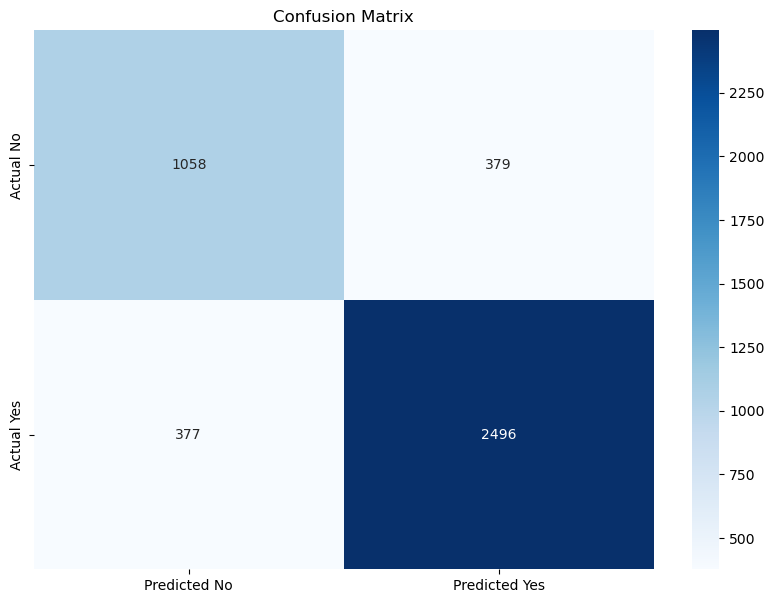

In [14]:
#Generate predictions
predictions = cart_model.predict(X_test)

#Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

#Get and plot confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.show()

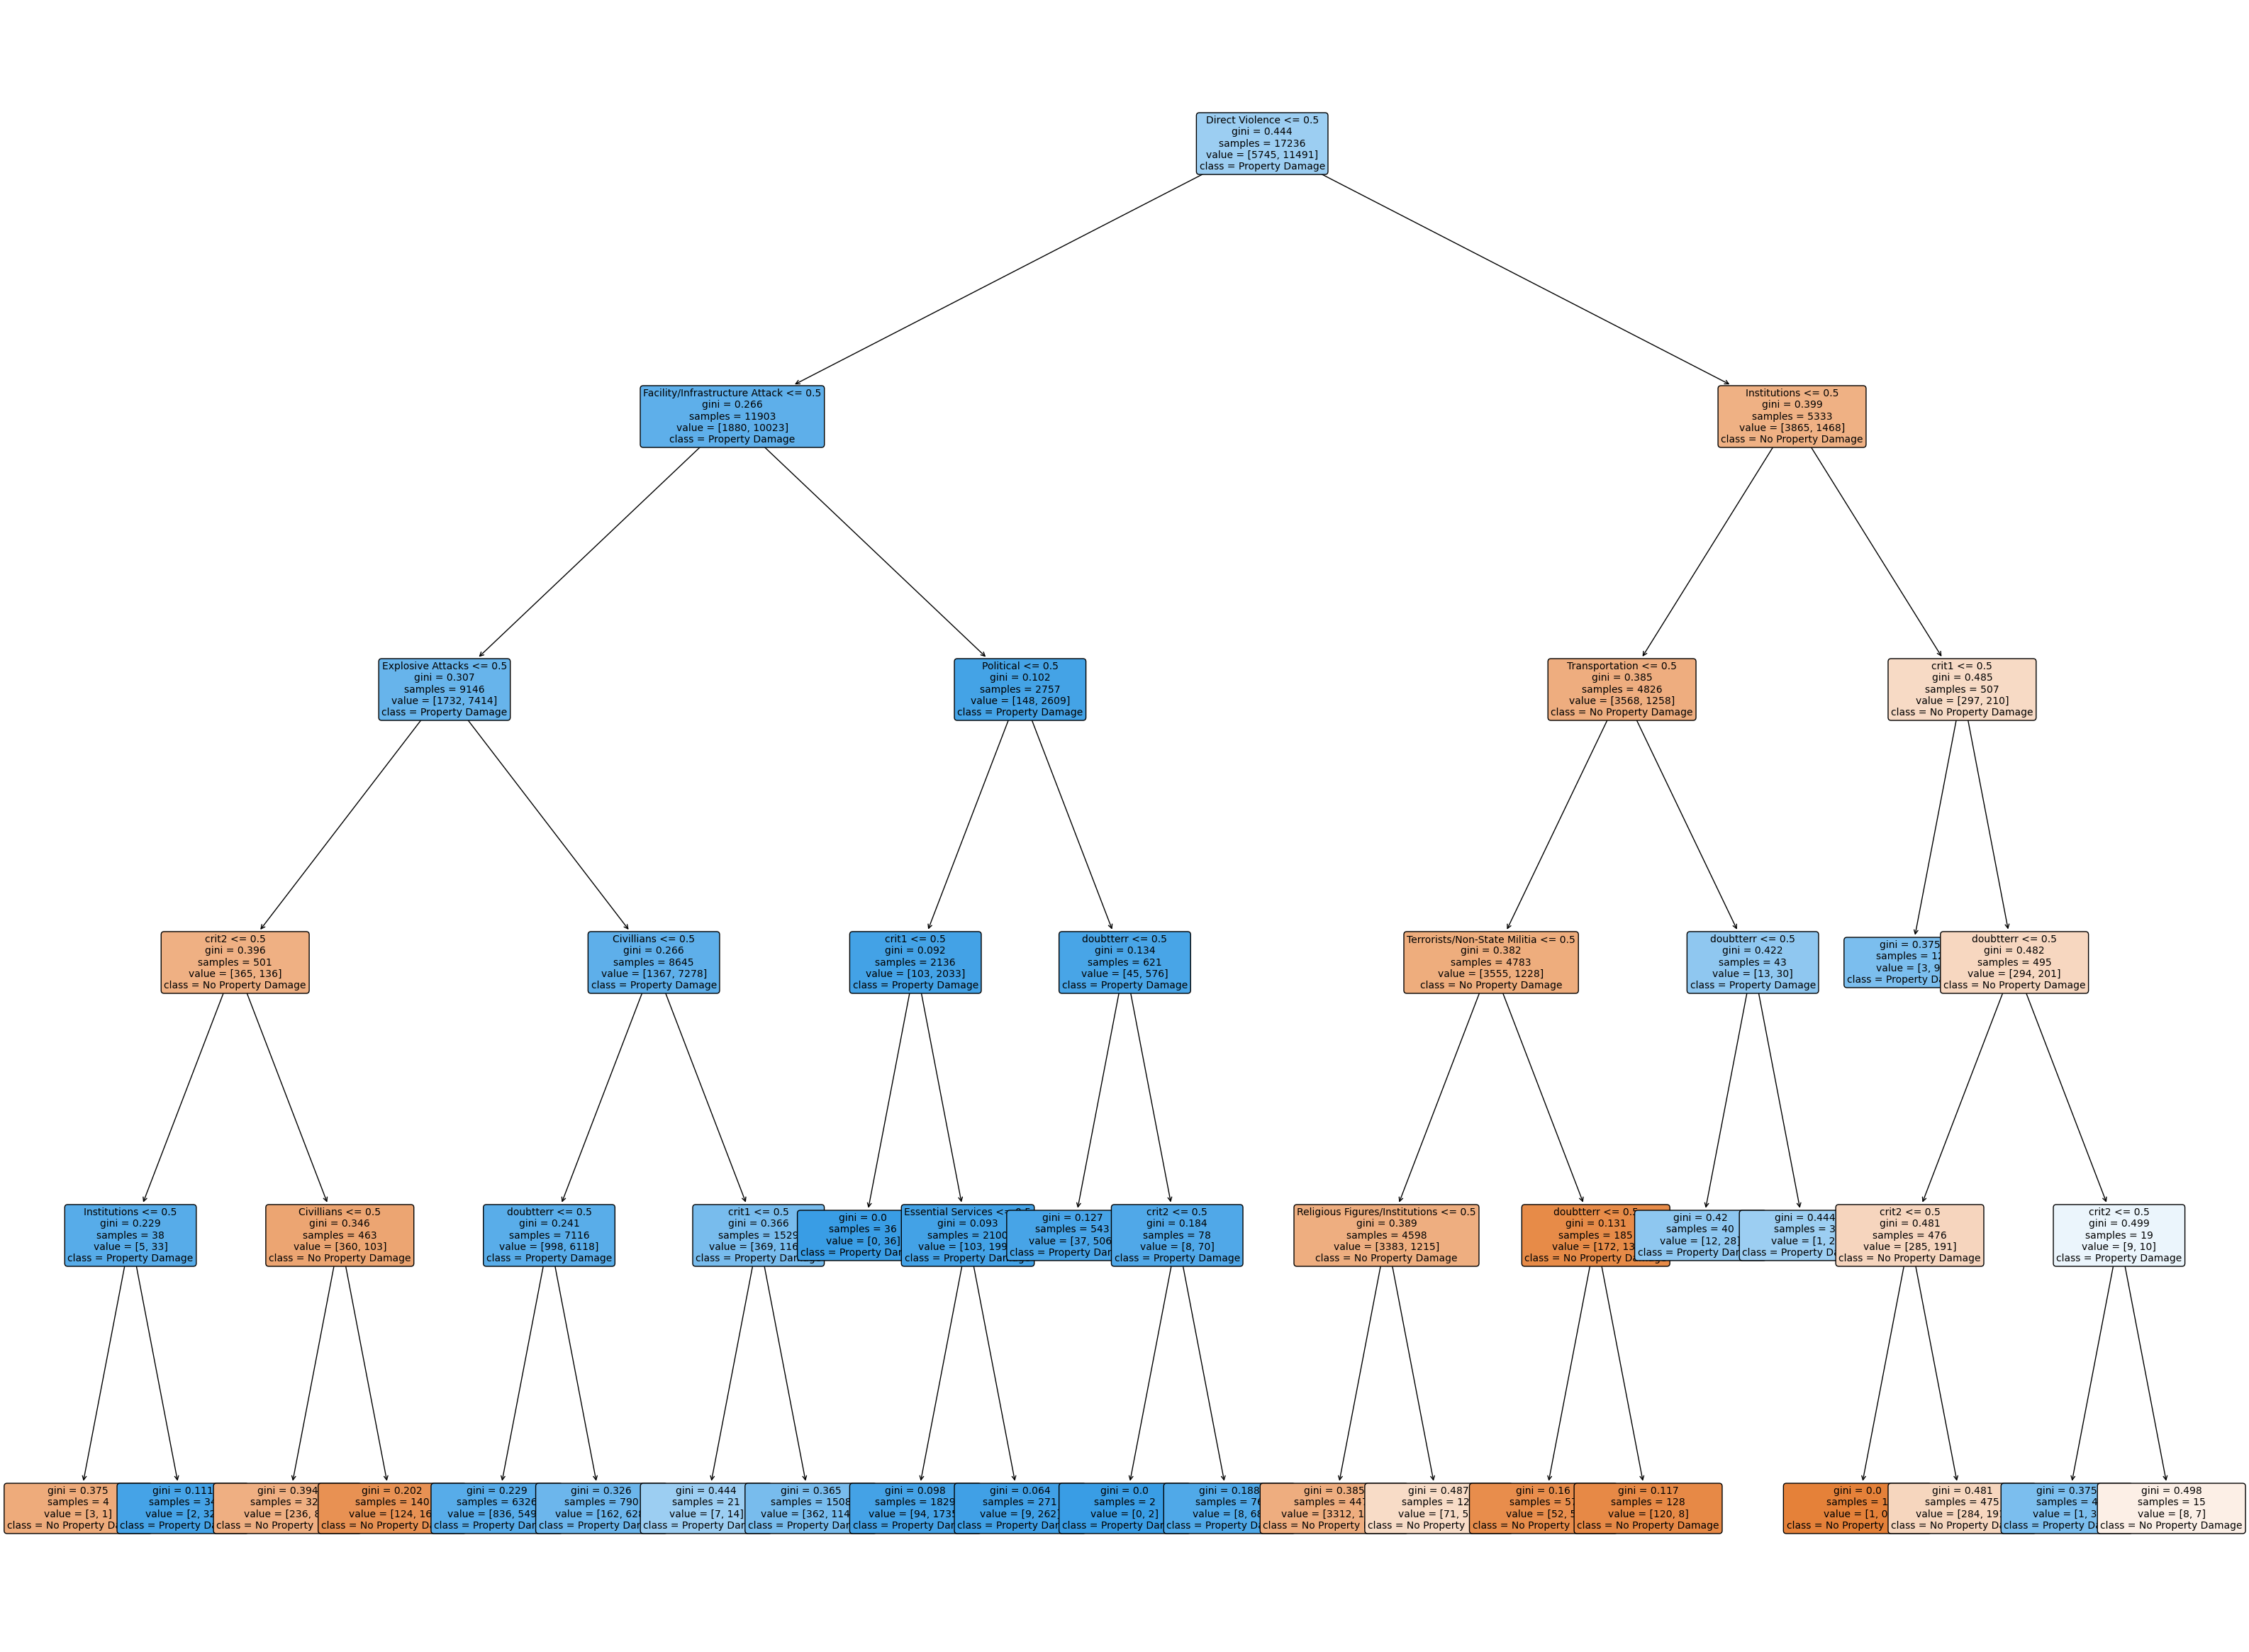

In [17]:
#Plot decision tree splits
plt.figure(figsize=(40,30))
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          class_names=['No Property Damage', 'Property Damage'], 
          feature_names=list(X_train.columns),
          fontsize=10)       
plt.show()


##### Interpretation of Tree
This lot shows the tree based decisions and splits made by the CART model. The root node is represented by direct violence attacks, from which we branch out into internal nodes depending on whether the threshold criteria is met. Blue colored nodes indicate property damage classification while orange/red (ish) cells indicate no property damage. We have only two colors since the output is binary. By looking at the plot it is clear that the main outcome predicted is property damage. A common, less important internal node in this tree is represented by crit2 (intention to intimidate or coerce).